In [2]:
%%time

#titanicコンペ
%matplotlib inline
import numpy as np
import pandas as pd
import re as re


#データファイルの読み込み
train = pd.read_csv("../../input/titanic/train.csv")
test = pd.read_csv("../../input/titanic/test.csv")
gender_submission = pd.read_csv("../../input/titanic/gender_submission.csv")


CPU times: user 9.15 ms, sys: 0 ns, total: 9.15 ms
Wall time: 8.8 ms


In [4]:
#kaggleではtrainとtestを結合
data = pd.concat([train,test])
print(data.shape)
data.head()

(1309, 12)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [5]:
#Sex:性別は文字列なので数値に変換する:inplaceオプションで元データも書き換え
data['Sex'].replace(['male','female'],[0, 1], inplace=True)

#Embarkedには欠損値があるので大多数を占める「S」でうめる
data['Embarked'].fillna(('S'), inplace=True)
##Embarkedは文字列なので数値に変換
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

#運賃も関係あるかも
#一つ欠損値が存在するため平均値で埋める
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

In [7]:
#ここまでは同じ
data['Sex'].value_counts()
data['Embarked'].value_counts()
#data['Fare'].value_counts()

0    916
1    270
2    123
Name: Embarked, dtype: int64

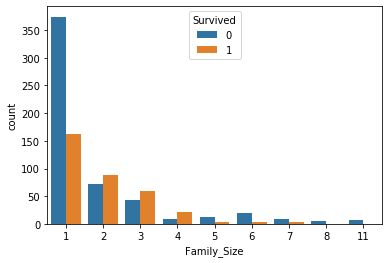

In [9]:
#家族の人数が多いと生存率がさがるのでは？という仮設を立てる
#「家族の人数」を示す特徴量を作る
#データの中に「Parch：兄弟姉妹/配偶者の数」、「SibSp：親子の数」があるので
#これを足して特徴量を生成
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1
train['Family_Size'] = data['Family_Size'][:len(train)]
test['Family_Size'] = data['Family_Size'][len(train):]

import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='Family_Size', data = train, hue = 'Survived')

In [10]:
#一人だけの乗客と5人以上の家族連れは生存率が低い
#「一人だけ」という特徴量も作る

data['IsAlone'] = 0
data.loc[data['Family_Size'] == 1, 'IsAlone'] = 1

train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1


In [11]:
#運賃も欠損値が存在するため平均値で埋める
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

In [12]:
#Age：年齢も加味してみる
age_avg = data['Age'].mean()
age_std = data['Age'].std()
#平均年齢に標準へ差の幅で欠損値を埋める
data['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)
train.head()

In [13]:
data.head()



,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,IsAlone
0,22.0,NaN,0,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,2,0
1,38.0,C85,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,2,0
2,26.0,NaN,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,1,1
3,35.0,C123,0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,2,0
4,35.0,NaN,0,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,1,1


In [14]:

#とりあえずここまでで特徴量を考慮しなかった列は削除
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis = 1, inplace = True)

In [15]:
#特徴量エンジニアリング後のデータについてtrainとtestにわける
train = data[:len(train)]
test = data[len(train):]

print(train.shape)
print(test.shape)

#x_train：学習データ、正解ラベル(Survived)の列は削除
#y_train：学習データ、正解ラベル(Survived)のみとする
#x_test：検証データ、正解ラベル(Survived)の列は削除

y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)
X_test = test.drop('Survived', axis = 1)

#確認
print("x_train:" + str(X_train.shape))
print("y_train:" + str(y_train.shape))
print("x_test:" + str(X_test.shape))

(891, 8)
(418, 8)
x_train:(891, 7)
y_train:(891,)
x_test:(418, 7)


In [16]:
%%time
#機械学習アルゴリズム
#ロジスティック回帰を用いる
from sklearn.linear_model import LogisticRegression

#カッコ内がハイパーパラメータ(機械学習アルゴの振る舞いを決定するパラメータ)の設定
#以下は適当でL正則化、最適化アルゴsag(詳細不明)、乱数のシード：指定しないと毎回結果が変わる
clf = LogisticRegression(penalty='l2', solver="sag", random_state=0)

#学習
clf.fit(X_train, y_train)

CPU times: user 51.5 ms, sys: 4.35 ms, total: 55.9 ms
Wall time: 74.4 ms


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [17]:
#モデルで評価してみる
y_pred = clf.predict(X_test)
y_pred[:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0.])

In [18]:
#cross validation
from sklearn.model_selection import train_test_split

#データセットを訓練データとテストデータに分ける
#訓練データ75%、テストデータ:25%に分割
x_train_cv,x_test_cv,y_train_cv,y_test_cv = train_test_split(X_train , y_train,random_state=0)

print("shape of x_train: {}".format(x_train_cv.shape))
print("shape of y_train: {}".format(y_train_cv.shape))

print("shape of x_test: {}".format(x_test_cv.shape))
print("shape of y_test: {}".format(y_test_cv.shape))

shape of x_train: (668, 7)
shape of y_train: (668,)
shape of x_test: (223, 7)
shape of y_test: (223,)


In [19]:
#路地スティク回帰
clf_logi = LogisticRegression(penalty='l2', solver="sag", random_state=0)

#学習
clf_logi.fit(x_train_cv, y_train_cv)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
#モデルで評価してみる
#y_pred = clf_logi.predict(x_test_cv)
                         
mdl_score = clf_logi.score(x_test_cv,y_test_cv)
print("model score : {:.3f}".format(mdl_score))

model score : 0.704
